# Ch2. 시계열 모델링 소개
데이터의 순서와 그 상관관계가 중요함
시계열 접근 방식의 우수성: 시간에 따른 관측치 사이의 상관관계가 현재 값을 더 잘 설명함
시간적 상관관계가 있는 데이터: I.I.D. 가정을 위반함

In [2]:
!pip install yfinance

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 29.9 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 30.7 MB/s  0:00:00
  Created wheel for multitasking: filename=multita

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


ticker = '^GSPC'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 1)
SP_prices = yf.download(ticker, start=start, end=end, interval='1mo').Close

: 

1. 추세
주어진 기간 동안 증가 or 감소하는 일반적인 경향
추세 확인 도구:
(i) 자기상관함수: 시계열의 현재 값과 그로부터 지연(lagged)된 값 사이의 관계 분석
$\hat{p}(h)=\frac{Cov(X_t,X_{t-h})}{Var(X_t)}$

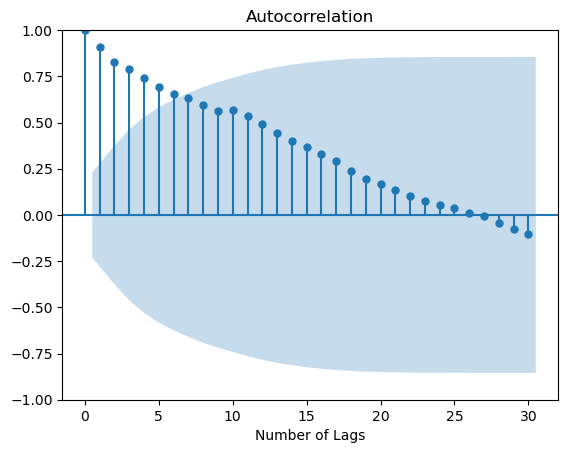

In [4]:
sm.graphics.tsa.plot_acf(SP_prices, lags=30)
import matplotlib.pyplot as plt
plt.xlabel('Number of Lags')
plt.show()

(ii) 부분 자기상관함수: 
$\hat{p}(h)=\frac{Cov(X_t,X_{t-h}|X_{t-1},X_{t-2},..,X_{t-h-1})}{\sqrt{Var(X_t|X_{t-1},..X_{t-h-1})Var(X_{t-h}|X_{t-1},..,X_{t-h-1})}}$
- h: 지연

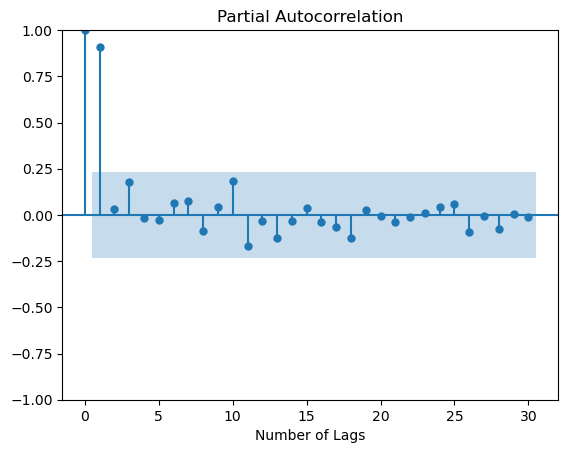

In [5]:
sm.graphics.tsa.plot_pacf(SP_prices, lags=30)
plt.xlabel('Number of Lags')
plt.show()

- 신뢰구간을 나타내는 어두운 영역 외부의 돌출에 초점을 맞춤
- 중간 효과를 분리하는 방식으로 계열의 현재 값과 지연 값 간의 상관관계를 측정함

2. 계절성
주어진 주기 동안 규칙적인 변화가 있는 경우

3. 주기성
추세보다 높은 주기적 변동이 나타날 때 존재함

4. 잔차: 시계열의 불규칙한 구성 요소
- 관측치와 연관된 적합치 사이으 차이
- 정상성(Stationarity): 시계열의 평균, 분산, 공분산과 같은 통계적 속성이 시간이 지남에 따라 변하지 않는 것
(i) 약한 정상성:
- 유한 분산, $E(X^2_t)<\infin, \forall t \in \mathbb{Z}$
- 평균 일정, 시간에만 종속됨 $E(X^2_t)=\mu,t \forall t \in \mathbb{Z}$
- 공분산구조 $\gamma(t,t+h)$는 시간차에만 종속됨: $\gamma(h)=\gamma_h+\gamma(t+h,t)$
- In conclusion, 시계열: 평균이 일정한 유한 분산과 시간차의 함수이 ㄴ공분산 구조 가짐
(ii) 강한 정상성
$(X_{t1},X_{t2},..,X_{tk})$ 결합분포가 $(X_{t1+h},X_{t2+h},...,X_{tk+h})$

- 정상성 필요 이유: (i) 예측가능성

In [ ]:
# 비정상성 감지 - 통계적 방법: ADF(Augmented Dickey Fuller) 테스트